In [31]:
from time import time
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import os


import errno
import shutil

In [32]:
def copy(src, dest):
    try:
        shutil.copytree(src, dest)
    except OSError as e:
        # If the error was caused because the source wasn't a directory
        if e.errno == errno.ENOTDIR:
            shutil.copy(src, dest)
        else:
            print('Directory not copied. Error: %s' % e)

In [33]:
src = '../input/'
dest = '../LFW/lfw_home'
copy(src,dest)

Directory not copied. Error: [Errno 17] File exists: '../LFW/lfw_home'


In [34]:


print(os.listdir('../input'))
print(os.listdir('../LFW/lfw_home'))

path = '../LFW/'

['pairsDevTrain.txt', 'lfw-funneled.tgz', 'pairsDevTest.txt', 'pairs.txt']
['joblib', 'lfw_funneled', 'pairs.txt', 'pairsDevTest.txt', 'pairsDevTrain.txt']


In [35]:

lfw_dataset = sklearn.datasets.fetch_lfw_people(data_home = path, min_faces_per_person=100,  download_if_missing = False)



In [36]:
n_samples, h, w = lfw_dataset.images.shape

X = lfw_dataset.data
n_features = X.shape[1]


y = lfw_dataset.target
target_names = lfw_dataset.target_names
n_classes = target_names.shape[0]

In [37]:
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1140
n_features: 2914
n_classes: 5


In [38]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [39]:


n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 855 faces
done in 0.174s


In [40]:
eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


Projecting the input data on the eigenfaces orthonormal basis
done in 0.018s


In [41]:

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


Fitting the classifier to the training set


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


done in 15.815s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [42]:


print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.059s
                   precision    recall  f1-score   support

     Colin Powell       0.92      0.94      0.93        64
  Donald Rumsfeld       0.96      0.81      0.88        32
    George W Bush       0.88      0.97      0.92       127
Gerhard Schroeder       0.92      0.83      0.87        29
       Tony Blair       0.96      0.79      0.87        33

         accuracy                           0.91       285
        macro avg       0.93      0.87      0.89       285
     weighted avg       0.91      0.91      0.91       285

[[ 60   0   4   0   0]
 [  0  26   4   1   1]
 [  4   0 123   0   0]
 [  1   0   4  24   0]
 [  0   1   5   1  26]]


In [43]:

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

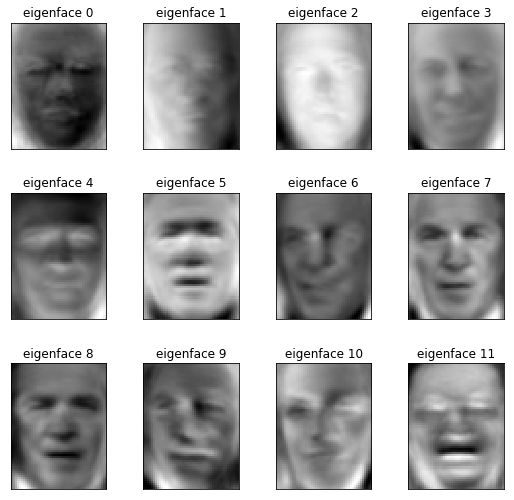

In [44]:


eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

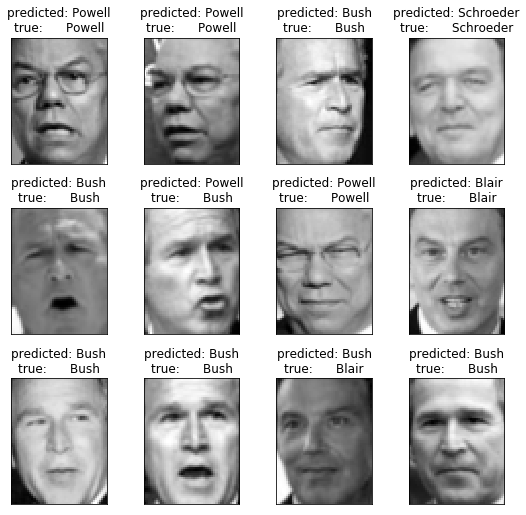

In [45]:


def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)